### 1. Import Necessary Data

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from autoreject import AutoReject
import mne
from mne.preprocessing import ICA

### 2. Load Data

To get the the data from the website, run this in command prompt
```
wget https://mindbigdata.com/opendb/MindBigData-EP-v1.0.zip
unzip MindBigData-EP-v1.0.zip
```

In [110]:
def load_mindbigdata_ep(filepath, max_samples=-1, max_samples_per_digit=500, 
                       required_channels=14, sample_length=256, apply_zscore=True):
    """
    Load data from MindBigData EPOC dataset WITHOUT min-max normalization.
    Only optional z-score normalization is applied (recommended for EEG).

    Parameters:
    - filepath: Path to the EP1.01.txt data file.
    - max_samples: Maximum number of lines to read (-1 for no limit).
    - max_samples_per_digit: Max samples per digit class (0-9).
    - required_channels: EEG channels per sample (default 14).
    - sample_length: Data points per channel (default 256).
    - apply_zscore: If True, applies z-score normalization per channel.

    Returns:
    - eeg_data: Raw EEG data (num_samples, 14, 256)
    - digit_labels: Corresponding labels (0-9)
    - samples_per_class: Counts per digit class
    """
    eeg_data = []
    digit_labels = []
    samples_per_class = [0] * 10

    with open(filepath, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        collected_lines = 0
        current_channels = []
        channel_counter = 0

        for row in reader:
            if max_samples != -1 and collected_lines >= max_samples:
                break

            if len(row) < 7:
                continue

            try:
                digit_code = int(row[4])
                signal_values = row[6].split(',')
            except (ValueError, IndexError):
                continue

            # Skip invalid digits or if class quota met
            if digit_code < 0 or digit_code > 9 or \
               samples_per_class[digit_code] >= max_samples_per_digit:
                continue

            if len(signal_values) < sample_length:
                continue

            # Store raw signal (convert to float32)
            signal_array = np.array(signal_values[:sample_length], dtype=np.float32)
            current_channels.append(signal_array)
            channel_counter += 1
            collected_lines += 1

            if channel_counter == required_channels:
                # Optional z-score (no min-max!)
                if apply_zscore:
                    normalized_channels = []
                    for ch in current_channels:
                        if np.std(ch) == 0:
                            break  # Skip bad channels
                        normalized_channels.append((ch - np.mean(ch)) / np.std(ch))
                    else:  # Only append if all channels are valid
                        eeg_data.append(np.array(normalized_channels))
                        digit_labels.append(digit_code)
                        samples_per_class[digit_code] += 1
                else:
                    eeg_data.append(np.array(current_channels))
                    digit_labels.append(digit_code)
                    samples_per_class[digit_code] += 1

                current_channels = []
                channel_counter = 0

    eeg_data = np.array(eeg_data)
    digit_labels = np.array(digit_labels)

    print(f"Collected samples per digit: {samples_per_class}")
    print(f"Final data shape: {eeg_data.shape}")
    return eeg_data, digit_labels, samples_per_class

In [111]:
CHANNEL_NAMES = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", 
                 "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
FS = 128

In [112]:
x_data, y_data, class_counts = load_mindbigdata_ep("EP1.01.txt", max_samples=50000, max_samples_per_digit=500)

Collected samples per digit: [360, 340, 355, 383, 343, 365, 350, 359, 361, 351]
Final data shape: (3567, 14, 256)


Here is the visualization of the data

In [115]:
def plot_stacked_eeg(eeg_sample, label, channel_names=CHANNEL_NAMES):
    """
    Plot a stacked EEG signal plot for one digit sample.
    Each channel is offset for clarity, sharing the same x-axis (samples).
    """
    plt.figure(figsize=(12, 6))
    n_channels = eeg_sample.shape[0]
    offset = 1

    for i in range(n_channels):
        plt.plot(eeg_sample[i] + i * offset, label=channel_names[i])

    plt.yticks(np.arange(0, n_channels * offset, offset), channel_names)
    plt.xlabel("Samples")
    plt.title(f"EEG Plot of Digit '{label}'")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
def plot_one_stacked_per_digit(x_data, y_data):
    plotted = set()
    for i in range(len(y_data)):
        digit = y_data[i]
        if digit not in plotted:
            plot_stacked_eeg(x_data[i], digit)
            plotted.add(digit)
        if len(plotted) == 10:
            break

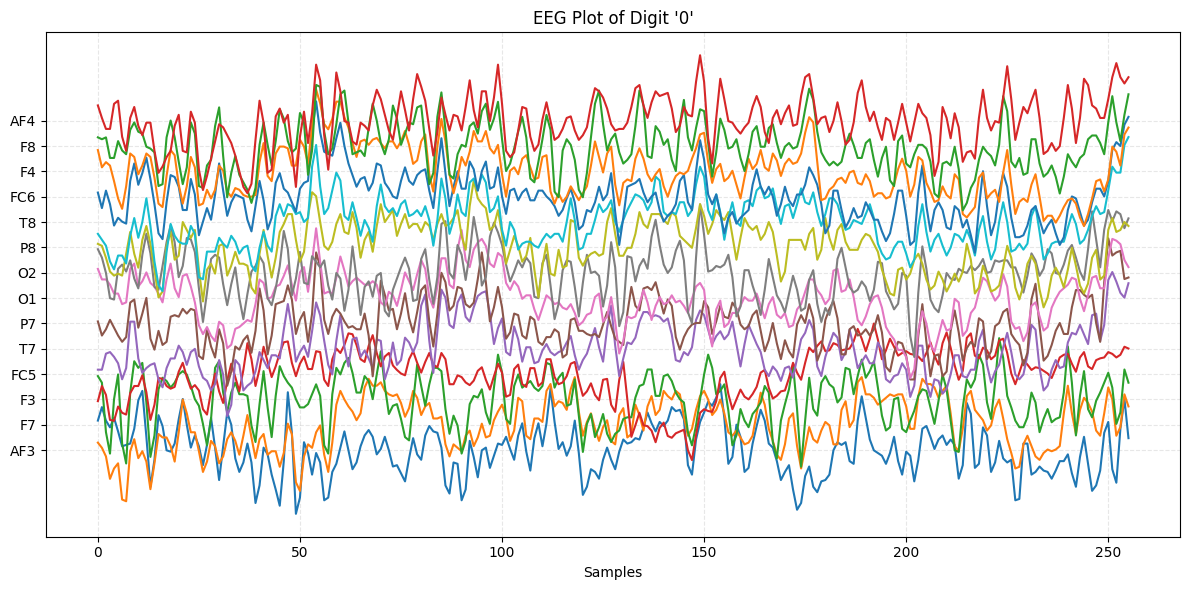

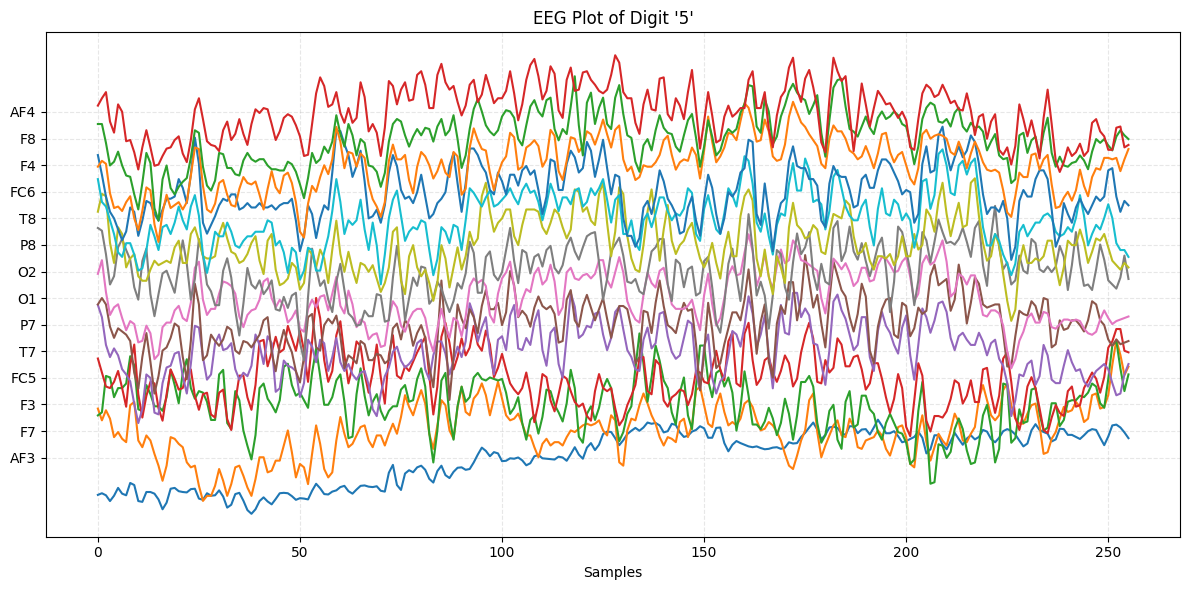

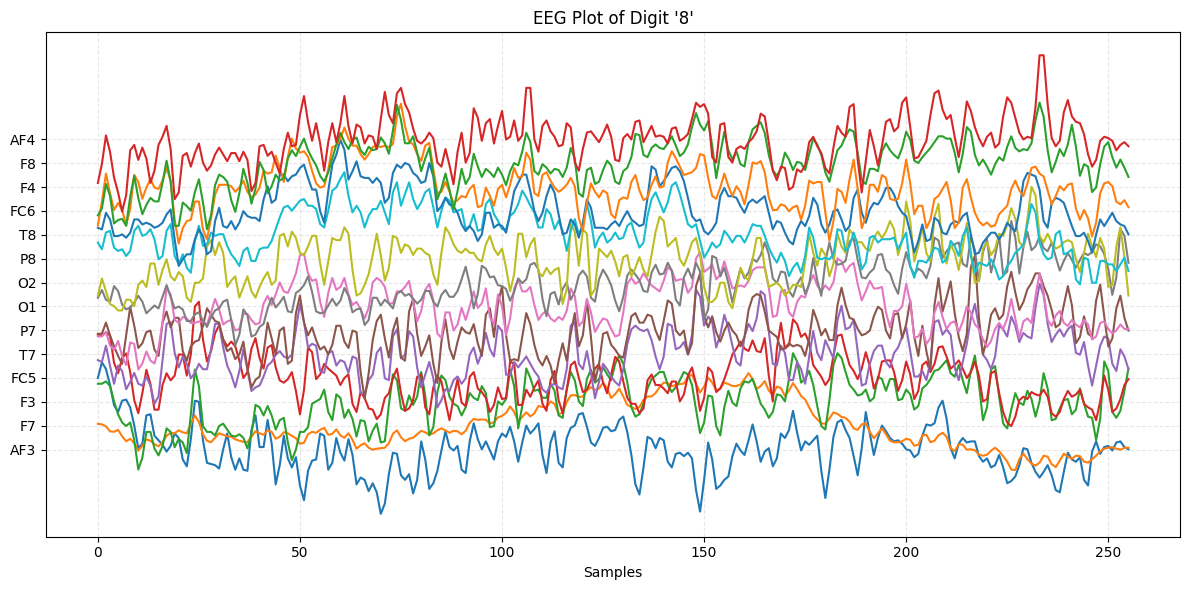

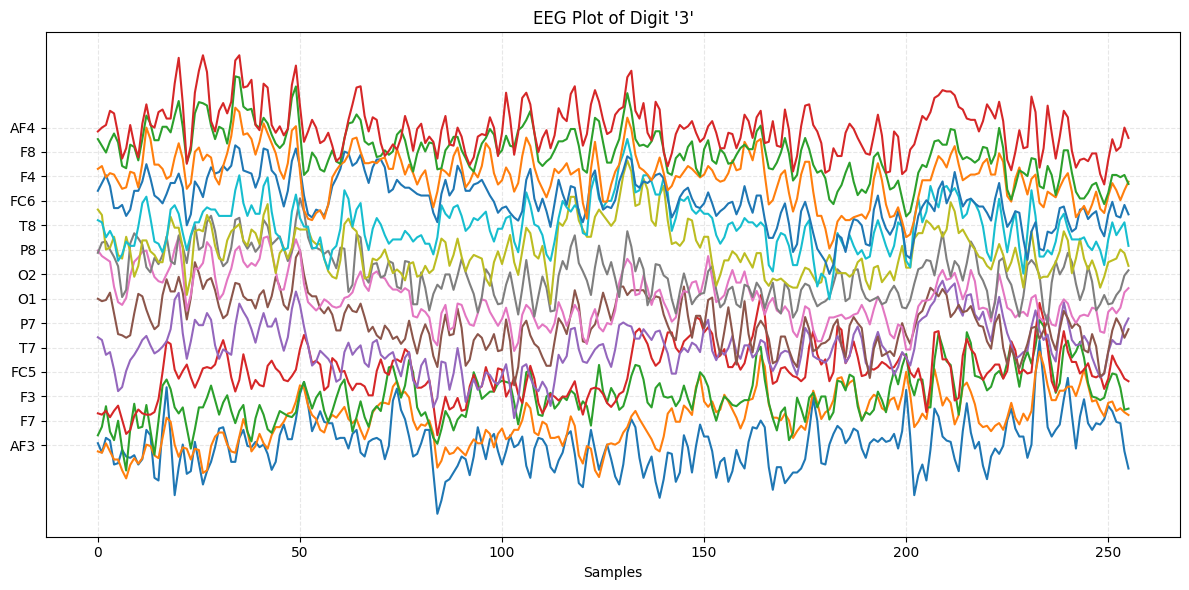

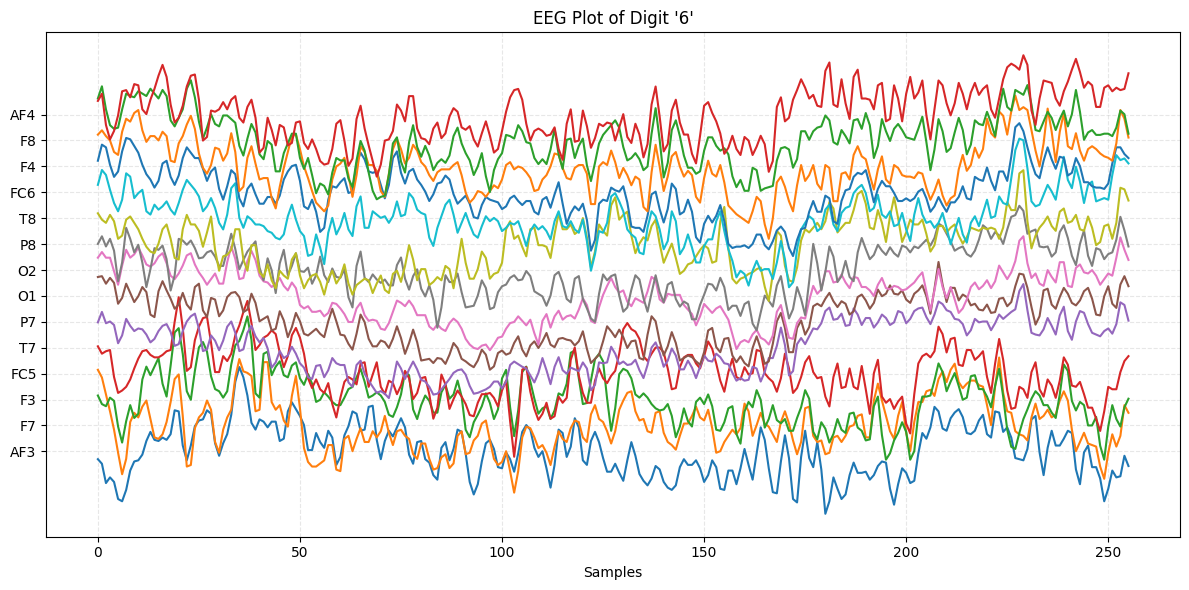

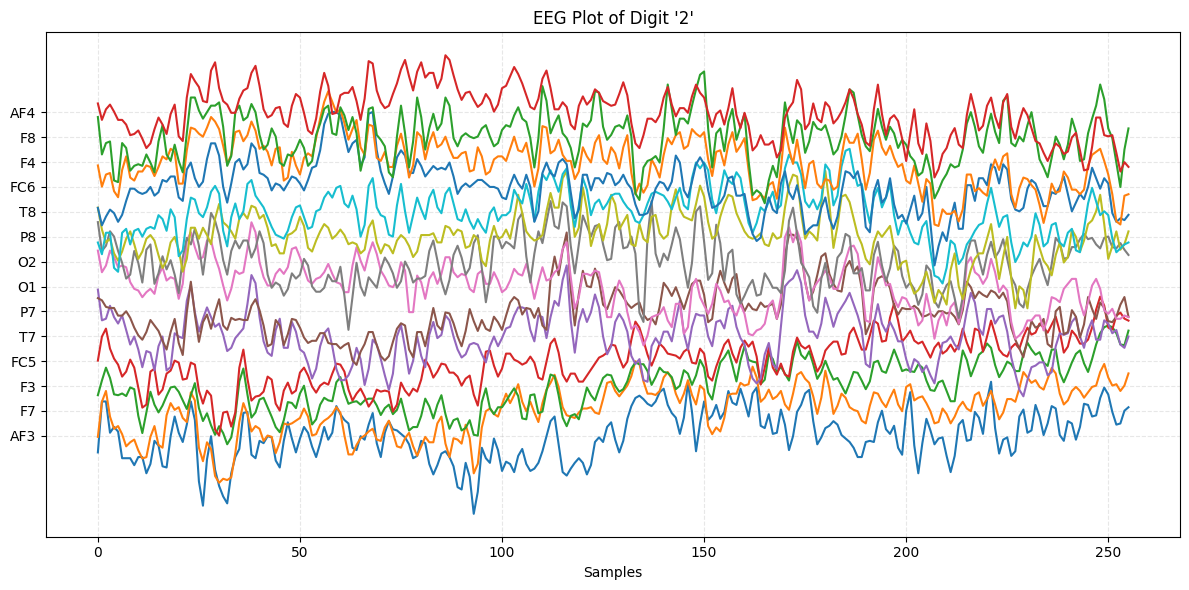

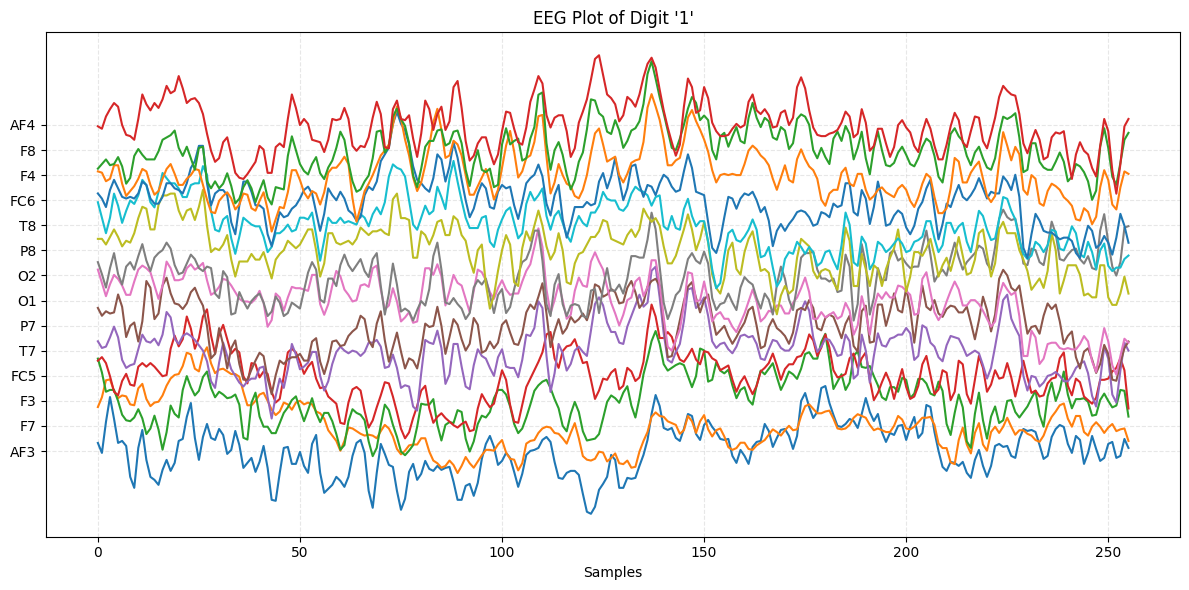

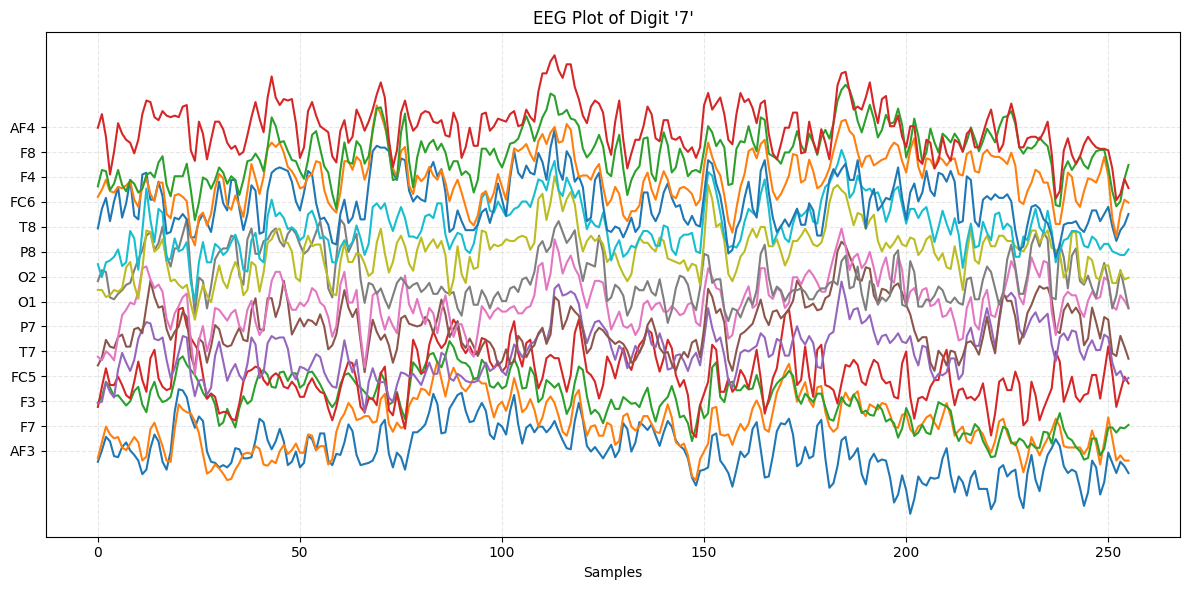

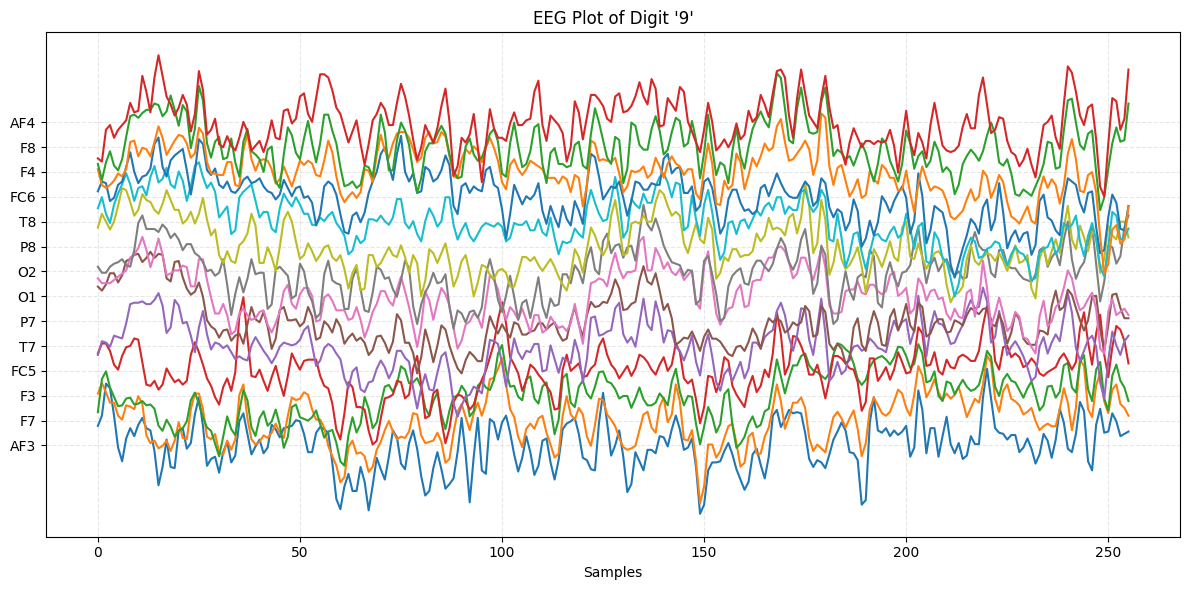

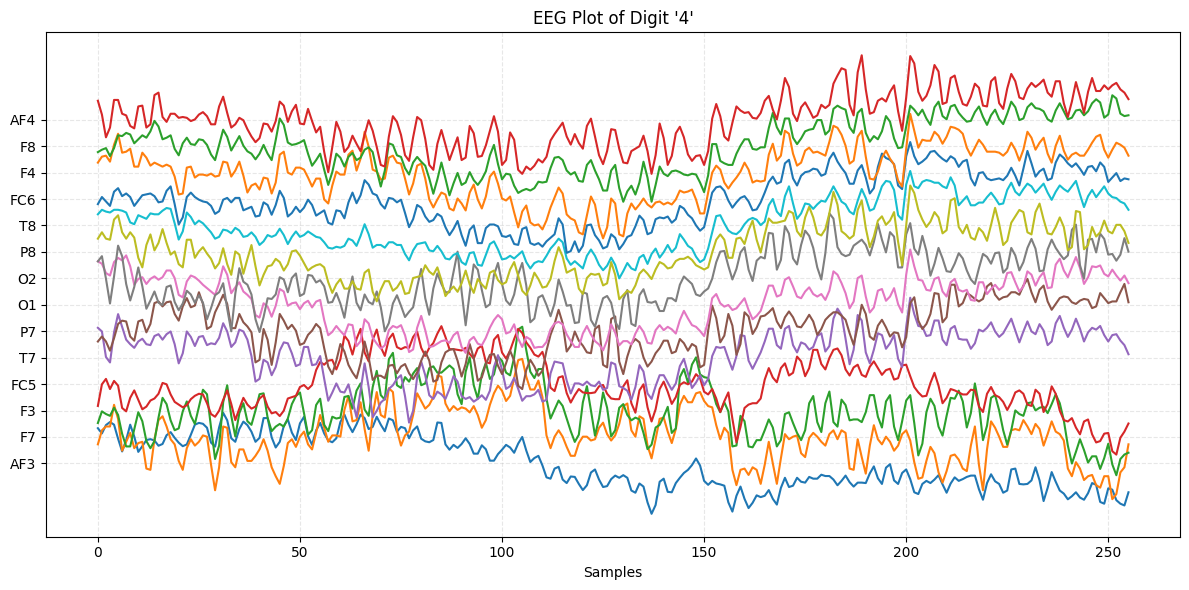

In [116]:
plot_one_stacked_per_digit(x_data, y_data)

### 3. Pre processing
#### 3.1. Bandpass Filtering
Purpose:
To isolate the frequency range relevant to brain activity and remove irrelevant noise.

	•	Removes low-frequency drift (e.g., skin potentials, motion artifacts).
    
	•	Removes high-frequency noise (e.g., muscle artifacts, line noise).
    
Typical EEG bands:
	•	Delta: 1–4 Hz
    
	•	Theta: 4–8 Hz
    
	•	Alpha: 8–13 Hz
    
	•	Beta: 13–30 Hz
    
	•	Gamma: 30–100 Hz

In [117]:
def butter_bandpass(lowcut, highcut, fs, order=4):
    """
    Create a Butterworth band-pass filter.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    return butter(order, [low, high], btype='band')

def apply_bandpass_filter(data, fs, lowcut=1.0, highcut=40.0, order=4):
    """
    Apply band-pass filter to 3D EEG data [samples, channels, time].
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = np.zeros_like(data)

    for i in range(data.shape[0]):         # for each sample
        for ch in range(data.shape[1]):    # for each channel
            filtered[i, ch, :] = filtfilt(b, a, data[i, ch, :])
    
    return filtered

In [118]:
x_filtered = apply_bandpass_filter(x_data, FS)

Here is visualization before and after Bandpass filtering

In [119]:
def plot_raw_vs_filtered(x_raw, x_filtered, sample_index=0, channel_index=0, channel_name="AF3", fs=128):
    """
    Plot raw and filtered EEG signal for one sample and one channel.
    
    Parameters:
        x_raw (ndarray): Raw EEG data, shape (samples, channels, time)
        x_filtered (ndarray): Filtered EEG data, same shape
        sample_index (int): Index of the sample to plot
        channel_index (int): Index of the EEG channel to plot
        channel_name (str): Label of the EEG channel
        fs (int): Sampling frequency in Hz
    """
    raw_signal = x_raw[sample_index, channel_index, :]
    filtered_signal = x_filtered[sample_index, channel_index, :]
    time = np.arange(len(raw_signal)) / fs  # Convert sample index to time in seconds

    plt.figure(figsize=(12, 5))
    plt.plot(time, raw_signal, label='Raw Signal', alpha=0.6)
    plt.plot(time, filtered_signal, label='Filtered Signal (1–40 Hz)', linewidth=2)
    plt.title(f'EEG Signal Before vs After Filtering\nSample #{sample_index} | Channel: {channel_name}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (normalized)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [88]:
plot_raw_vs_filtered(x_data, x_filtered, sample_index=0, channel_index=0, channel_name="AF3", fs=128)

#### 3.2. Artifact Removal 1: Autoreject + ICA
Purpose:
To automatically detect and fix or drop bad epochs using machine learning.

	•	Finds channels with noisy spikes in an epoch and interpolates them.
    
	•	Can drop the whole epoch if it’s too corrupted.
    
	•	Learns thresholds for rejecting based on your data.
    
	•	Prevents garbage data from contaminating your model training.

In [99]:
# ==== Convert NumPy → MNE Epochs ====
def convert_to_epochs(x_data, sfreq=FS):
    """
    Convert filtered NumPy EEG data to MNE EpochsArray with 10-20 montage.
    """
    info = mne.create_info(ch_names=CHANNEL_NAMES, sfreq=sfreq, ch_types='eeg')
    
    # Add standard montage (needed for AutoReject and ICA topographies)
    montage = mne.channels.make_standard_montage('standard_1020')
    info.set_montage(montage)

    events = np.array([[i, 0, 1] for i in range(len(x_data))])
    return mne.EpochsArray(x_data, info, events=events, event_id={'stim': 1}, verbose=False)

In [91]:
# ==== Apply AutoReject ====
def apply_autoreject(x_filtered):
    epochs = convert_to_epochs(x_filtered)
    ar = AutoReject(random_state=42, verbose=True)
    epochs_clean = ar.fit_transform(epochs)
    return epochs, epochs_clean, ar

In [92]:
# ==== Apply ICA ====
def apply_ica(epochs_clean):
    ica = ICA(n_components=14, method='fastica', random_state=42)
    ica.fit(epochs_clean)
    return ica

In [107]:
def plot_autoreject_heatmap(ar_model, epochs):
    fig = ar_model.get_reject_log(epochs).plot()
    fig.suptitle("AutoReject Heatmap", fontsize=14)
    plt.show()

def plot_overlay(epochs_before, epochs_clean):
    data_before = epochs_before.get_data().mean(axis=0)
    data_after = epochs_clean.get_data().mean(axis=0)
    plt.figure(figsize=(10, 4))
    plt.plot(data_before.T, color='red', alpha=0.3, label='Before')
    plt.plot(data_after.T, color='black', alpha=0.7, label='After')
    plt.title("Signal Before (red) vs After (black) Cleaning (mean)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_scrollable(epochs_clean):
    epochs_clean.plot(n_epochs=20, n_channels=14, scalings='auto')

In [101]:
# Step 1: AutoReject
epochs_before, epochs_clean, ar_model = apply_autoreject(x_filtered)

# Step 2: ICA
ica_model = apply_ica(epochs_clean)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/3567 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/3567 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/3567 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/3567 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1


  0%|          | Repairing epochs : 0/3567 [00:00<?,       ?it/s]

Dropped 32 epochs: 142, 160, 161, 237, 398, 404, 421, 450, 644, 649, 658, 734, 842, 978, 1002, 1225, 1572, 1576, 1813, 1814, 1944, 2021, 2110, 2229, 2233, 2236, 2247, 2435, 2651, 2809, 2958, 3194
Fitting ICA to data using 14 channels (please be patient, this may take a while)


/tmp/ipykernel_861621/1374787538.py:4: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(epochs_clean)


Selecting by number: 14 components
Fitting ICA took 6.2s.


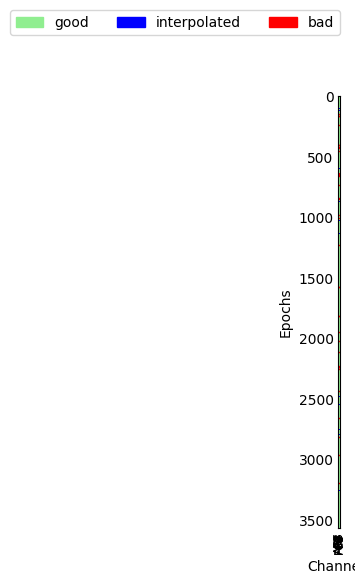

In [108]:
# Step 3: Visualizations
plot_autoreject_heatmap(ar_model, epochs_before)
plot_overlay(epochs_before, epochs_clean)
plot_scrollable(epochs_clean)